# Fuel assembly: 2Q with homogenized grid

## Import modules

In [41]:
import sys
import os
import pathlib
import re

import openmc
import openmc.mgxs as mgxs

import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
from prettytable import PrettyTable

## Add location of OpenMC XS executable, setup ENDF xs path

In [42]:
# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
#os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
#%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-vii.1-hdf5/cross_sections.xml

# Are you ragusa?
your_files = os.getcwd()
if 'ragusa' in your_files:
    os.environ['OPENMC_CROSS_SECTIONS'] = '/home/ragusa/xs/endfb-viii.0-hdf5/cross_sections.xml'

# Start model

In [43]:
model=openmc.Model()

## Define Materials
***

In [44]:
uo2 = openmc.Material(name='uo2')

uo2.add_nuclide('U234', 6.11864E-06, 'ao')
uo2.add_nuclide('U235', 7.18132E-04, 'ao')
uo2.add_nuclide('U236', 3.29861E-06, 'ao')
uo2.add_nuclide('U238', 2.21546E-02, 'ao')
uo2.add_nuclide('O16', 4.57642E-02, 'ao')

uo2.set_density('g/cm3', 10.257 )

uo2.temperature = 565

In [45]:
zirconium = openmc.Material(name="zirconium")

zirconium.add_nuclide('Zr90',  2.18865E-02, 'ao')
zirconium.add_nuclide('Zr91',  4.77292E-03, 'ao')
zirconium.add_nuclide('Zr92',  7.29551E-03, 'ao')
zirconium.add_nuclide('Zr94',  7.39335E-03, 'ao')
zirconium.add_nuclide('Zr96',  1.19110E-03, 'ao')
zirconium.add_nuclide('Sn112', 4.68066E-06, 'ao')
zirconium.add_nuclide('Sn114', 3.18478E-06, 'ao')
zirconium.add_nuclide('Sn115', 1.64064E-06, 'ao')
zirconium.add_nuclide('Sn116', 7.01616E-05, 'ao')
zirconium.add_nuclide('Sn117', 3.70592E-05, 'ao')
zirconium.add_nuclide('Sn118', 1.16872E-04, 'ao')
zirconium.add_nuclide('Sn119', 4.14504E-05, 'ao')
zirconium.add_nuclide('Sn120', 1.57212E-04, 'ao')
zirconium.add_nuclide('Sn122', 2.23417E-05, 'ao')
zirconium.add_nuclide('Sn124', 2.79392E-05, 'ao')
zirconium.add_nuclide('Fe54',  8.68307E-06, 'ao')
zirconium.add_nuclide('Fe56',  1.36306E-04, 'ao')
zirconium.add_nuclide('Fe57',  3.14789E-06, 'ao')
zirconium.add_nuclide('Fe58',  4.18926E-07, 'ao')
zirconium.add_nuclide('Cr50',  3.30121E-06, 'ao')
zirconium.add_nuclide('Cr52',  6.36606E-05, 'ao')
zirconium.add_nuclide('Cr53',  7.21860E-06, 'ao')
zirconium.add_nuclide('Cr54',  1.79686E-06, 'ao')
zirconium.add_nuclide('Hf174', 3.54138E-09, 'ao')
zirconium.add_nuclide('Hf176', 1.16423E-07, 'ao')
zirconium.add_nuclide('Hf177', 4.11686E-07, 'ao')
zirconium.add_nuclide('Hf178', 6.03806E-07, 'ao')
zirconium.add_nuclide('Hf179', 3.01460E-07, 'ao')
zirconium.add_nuclide('Hf180', 7.76449E-07, 'ao')

zirconium.set_density('g/cm3',  6.56)

zirconium.temperature = 565

In [46]:
water = openmc.Material(name="water")

water.add_nuclide('H1',  4.96224E-02, 'ao')
water.add_nuclide('O16', 2.48112E-02, 'ao')
water.add_nuclide('B10', 1.07070E-05, 'ao')
water.add_nuclide('B11', 4.30971E-05, 'ao')

#Unfortunately, you cannot do mix material function with this attribute
#water.add_s_alpha_beta('c_H_in_H2O')

water.set_density('g/cm3', 0.743)

water.temperature=565

In [47]:
helium = openmc.Material(name="helium")

helium.add_nuclide('He4',1, 'ao')

helium.set_density('g/cm3', 0.178E-03 )

helium.temperature=565

## Define individiual cells
***

In [48]:
# Global surfaces
pitch = 1.26

# Fuel radii
fuel_outer_radius = openmc.ZCylinder(r=0.4096)
clad_inner_radius = openmc.ZCylinder(r=0.418)
clad_outer_radius = openmc.ZCylinder(r=0.475)

# Guide tube radii
gt_inner_radius = openmc.ZCylinder(r=0.561)
gt_outer_radius = openmc.ZCylinder(r=0.602)

# Instrumentation radii
it_inner_radius = openmc.ZCylinder(r=0.559)
it_outer_radius = openmc.ZCylinder(r=0.605)

# Universe bounds
left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
right  = openmc.XPlane( pitch/2, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
top    = openmc.YPlane( pitch/2, boundary_type='transmission')


In [49]:
#Grid mass
grid_mass=875/289
grid_height = 3.810

#Volume of water for each cell
water_volume_fuel = ((pitch**2) -((clad_outer_radius.r**2)*np.pi))*grid_height
water_volume_gt= ((pitch**2) -((gt_outer_radius.r**2)*np.pi)+((gt_inner_radius.r**2)*np.pi))*grid_height
water_volume_it=((pitch**2) -((it_outer_radius.r**2)*np.pi)+((it_inner_radius.r**2)*np.pi))*grid_height

#Mass of water for each cell
water_mass_fuel = water_volume_fuel*water.density
water_mass_gt = water_volume_gt*water.density
water_mass_it = water_volume_it*water.density

#Weight fraction for each cell of water and grid
water_frac_fuel = water_mass_fuel/(water_mass_fuel+grid_mass)
grid_frac_fuel = grid_mass/(water_mass_fuel+grid_mass)
water_frac_gt = water_mass_gt/(water_mass_gt+grid_mass)
grid_frac_gt = grid_mass/(water_mass_gt+grid_mass)
water_frac_it = water_mass_it/(water_mass_it+grid_mass)
grid_frac_it = grid_mass/(water_mass_it+grid_mass)

#Homogenize
fuel_water=openmc.Material.mix_materials([water, zirconium], [water_frac_fuel, grid_frac_fuel], 'wo')
gt_water=openmc.Material.mix_materials([water, zirconium], [water_frac_gt, grid_frac_gt], 'wo')
it_water=openmc.Material.mix_materials([water, zirconium], [water_frac_it, grid_frac_it], 'wo')


In [50]:
model.materials = openmc.Materials([uo2, zirconium, fuel_water,gt_water,it_water,helium,water]) 
print(model.materials)

[Material
	ID             =	8
	Name           =	uo2
	Temperature    =	565
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]
, Material
	ID             =	9
	Name           =	zirconium
	Temperature    =	565
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	4.14504e-05 

### Define pincell universe

In [51]:
def pincell():

    fuel_region  = -fuel_outer_radius
    gap_region   = +fuel_outer_radius & -clad_inner_radius
    clad_region  = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius

    fuel = openmc.Cell(name='fuel')
    fuel.region = fuel_region
    fuel.fill = uo2
    #new_fuel = uo2.clone()
    #fuel.fill = new_fuel
    
    gap = openmc.Cell(name='fuel gap')
    gap.region = gap_region
    gap.fill = helium     
    
    clad = openmc.Cell(name='fuel clad')
    clad.region = clad_region
    clad.fill = zirconium
    
    moderator = openmc.Cell(name='moderator')
    moderator.region = water_region
    moderator.fill = fuel_water
    
    return openmc.Universe(name='pin-univ', cells=(fuel, clad, moderator,gap))

### Create guide tube universe

In [52]:
def guide():
    
    gt_water_in_region  = -gt_inner_radius
    gt_clad_region      = +gt_inner_radius & -gt_outer_radius
    gt_water_out_region = +gt_outer_radius & +left & -right & +bottom & -top
     
    gt_water_in = openmc.Cell(name='gt-water-in')
    gt_water_in.region = gt_water_in_region
    gt_water_in.fill = water
 
    gt_clad = openmc.Cell(name='gt-clad')
    gt_clad.region = gt_clad_region
    gt_clad.fill = zirconium

    gt_water_out = openmc.Cell(name='gt-water-out')
    gt_water_out.region = gt_water_out_region
    gt_water_out.fill = gt_water
    
    return openmc.Universe(name='gt-univ', cells=(gt_water_in, gt_clad, gt_water_out))

### Create instrumentation tube universe

In [53]:
def instrument():
    
    it_water_in_region  = -it_inner_radius
    it_clad_region      = +it_inner_radius & -it_outer_radius
    it_water_out_region = +it_outer_radius & +left & -right & +bottom & -top
    
    it_water_in = openmc.Cell(name='it-water-in')
    it_water_in.region = it_water_in_region
    it_water_in.fill = water

    it_clad = openmc.Cell(name='it-clad')
    it_clad.region = it_clad_region
    it_clad.fill = zirconium

    it_water_out = openmc.Cell(name='it-water-out')
    it_water_out.region = it_water_out_region
    it_water_out.fill = it_water

    return openmc.Universe(name='it-univ', cells=(it_water_in, it_clad, it_water_out))

### Generate universes

In [54]:
pc_univ  = pincell()
gt_univ  = guide()
it_univ  = instrument()

## Generate assembly
***

In [55]:
height = 10 # height in z-dir
dr = 0.04   # cm of water that is outside assembly
one_eighth = True # either 1/8 or 1/4 of FA

In [56]:
def read_csv_to_2d_array(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        data = [row for row in reader]
    return np.asarray(data)

def count_frequencies(data):
    flattened_data = [item for row in data for item in row]  # Flatten 2D array into a 1D list
    cell_frequencies = Counter(flattened_data)
    print("cell name frequency:")
    total = 0
    for key, value in cell_frequencies.items():
        print(f'"{key}": {value}')
        total += value
    print("total: ",total)

csv_filepath = 'FA_cell_names_1_family.csv'

lattice_csv = read_csv_to_2d_array(csv_filepath)
count_frequencies(lattice_csv)

if lattice_csv.shape[0] != lattice_csv.shape[1]:
    raise Exception('CSV array of cell names is not square.')
    
size = lattice_csv.shape[0] #size of the assembly 

cell name frequency:
"fu": 264
"gt": 24
"it": 1
total:  289


### Define assembly lattice

In [57]:
assembly = openmc.RectLattice()
assembly.pitch = (pitch,pitch)
assembly.lower_left = (-size*pitch/2, -size*pitch/2)

lattice_array = np.empty((size, size), dtype=openmc.universe.Universe)

for row in range(0,lattice_csv.shape[0]):
    for col in range(0,lattice_csv.shape[1]):
        if lattice_csv[row][col] == 'gt': 
            lattice_array[row][col] = gt_univ
        elif lattice_csv[row][col] == 'it':
            lattice_array[row][col] = it_univ
        elif lattice_csv[row][col] == 'fu':
            lattice_array[row][col] = pc_univ
        else:
            mesg = 'i={},j={},cell-name {} not recognized'.format(col, row, lattice_csv[row][col])
            raise ValueError(mesg)

assembly.universes = lattice_array

### Define moderator outside of the assembly

In [58]:
# create cell that will contain the lattice
moderator_outside_cell = openmc.Cell( name = 'water_outside', fill = water )
assembly.outer = openmc.Universe( name='outer', cells = [moderator_outside_cell] )

### Define 1/8 or 1/4 of full assembly

In [59]:
min_x = openmc.XPlane(x0= 0.               , boundary_type='reflective')
max_x = openmc.XPlane(x0= size*pitch/2+dr  , boundary_type='reflective')
min_y = openmc.YPlane(y0= 0.               , boundary_type='reflective')
max_y = openmc.YPlane(y0= size*pitch/2+dr  , boundary_type='reflective')
min_z = openmc.ZPlane(z0=-height/2         , boundary_type='reflective')
max_z = openmc.ZPlane(z0= height/2         , boundary_type='reflective')
xy    = openmc.Plane(-1., 1.               , boundary_type='reflective')

# define root universe
root_cell = openmc.Cell( name = 'root cell', fill = assembly )

if one_eighth:
    root_cell.region = -max_x & +min_y & -xy
else:
    root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name = 'root universe', cells=[root_cell])

## Plotting

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

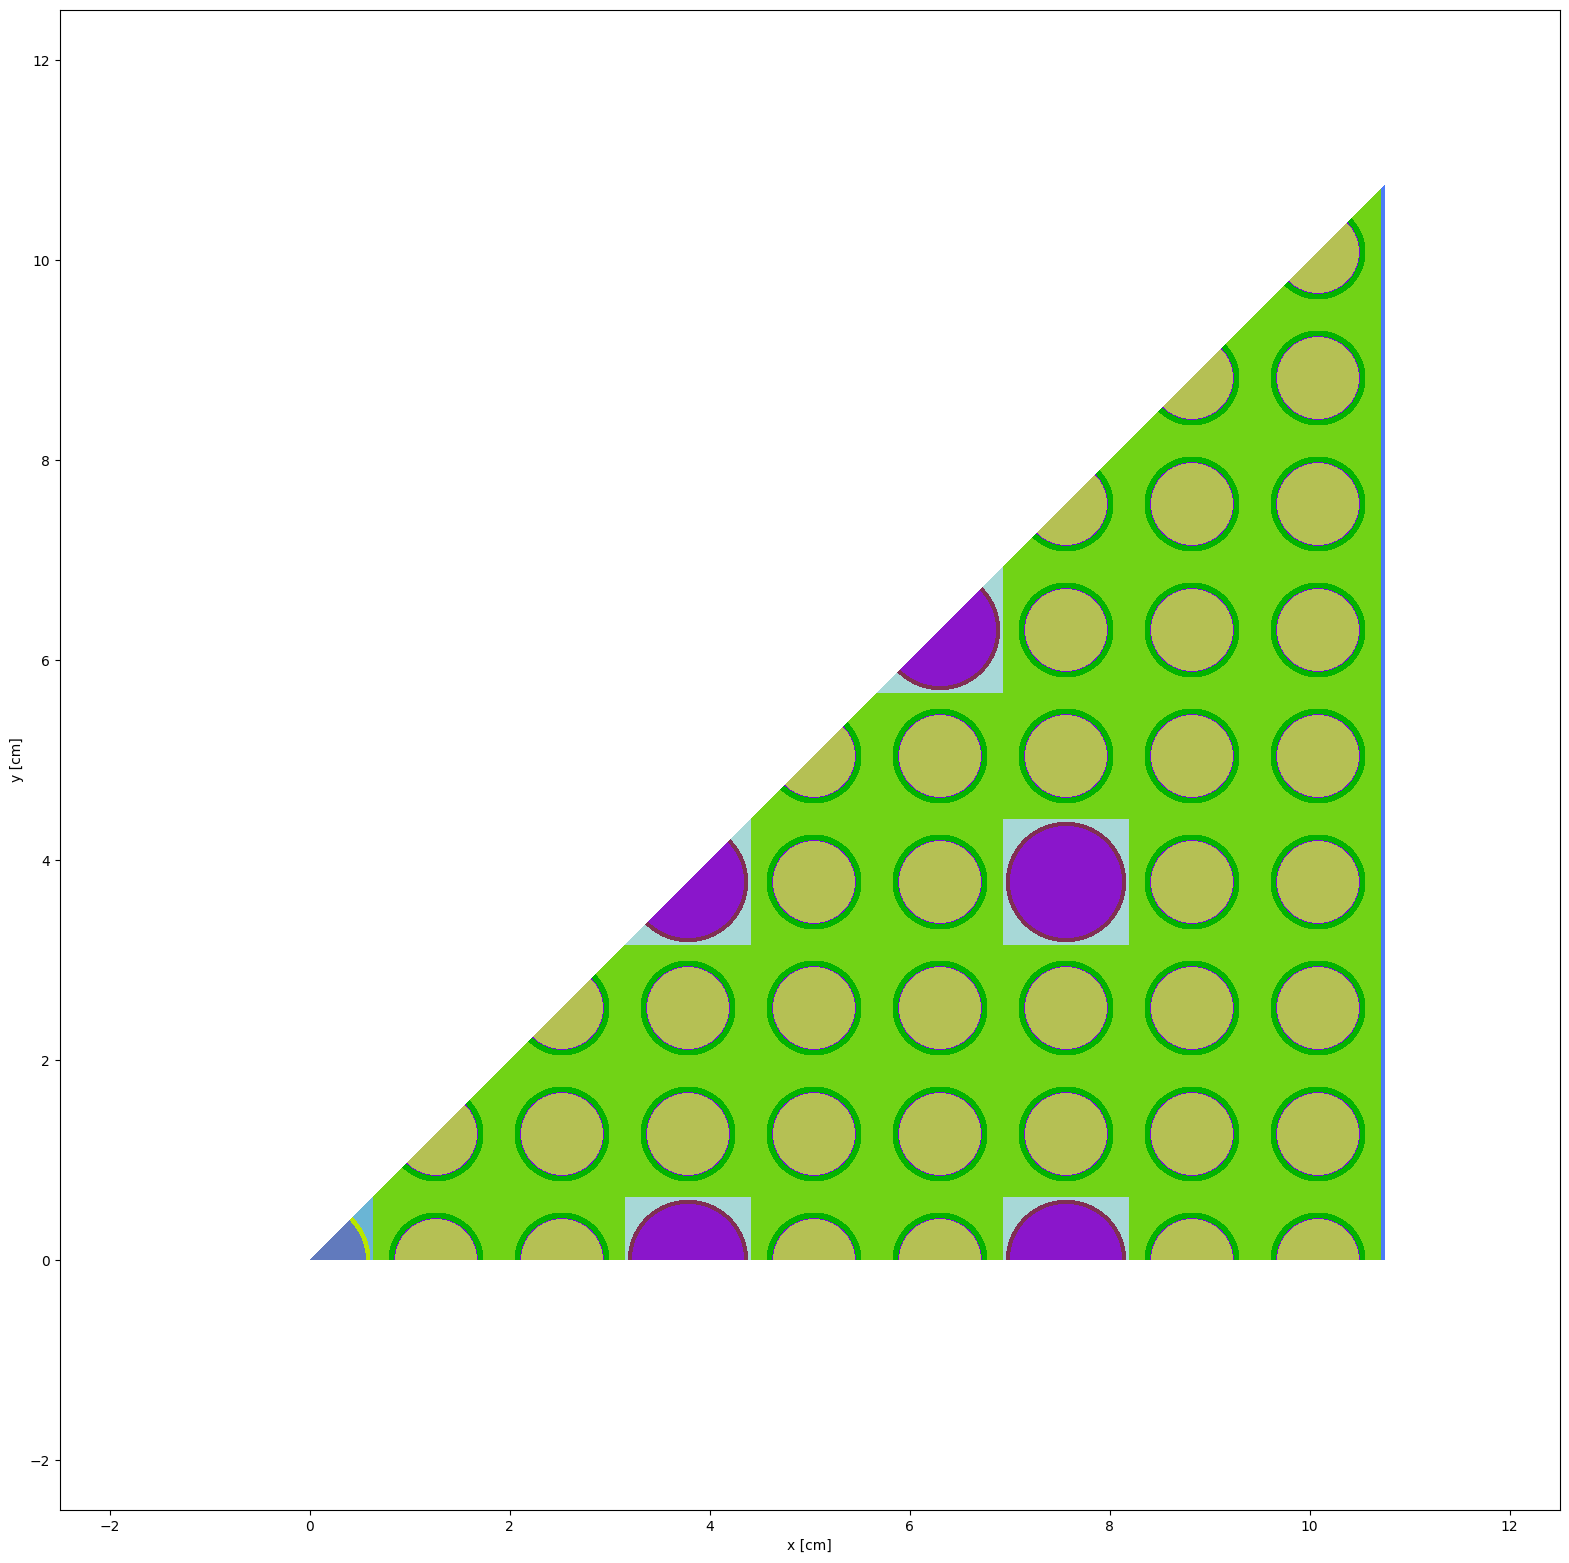

In [60]:
color_opt = 'cell' # 'material'
root_cell.plot(origin=(5,5,0), pixels=(1500,1500), width=(15,15),color_by=color_opt,outline=False)

##  Settings
***

In [21]:
settings = openmc.Settings()

### Source

In [22]:
bbox = openmc.BoundingBox(lower_left  = [0., 0., -height/2], 
                          upper_right = [size*pitch/2, size*pitch/2, height/2])
uniform_dist = openmc.stats.Box(bbox.lower_left, bbox.upper_right, only_fissionable=True)
source = openmc.IndependentSource(space=uniform_dist)
settings.source = source

/home/brent10/openmc/lib/python3.12/site-packages/openmc/stats/multivariate.py:943: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "


### Destination path

In [23]:
my_case = '2q_homogenized'
my_path = './mgxs_casl_' + my_case

# check if folder exists
path = pathlib.Path(my_path)
path.mkdir(parents = True, exist_ok = True)

### Batching

In [24]:
test_mode = False

In [25]:
# add additional parameters
settings.batches =  150
settings.inactive = 20
settings.particles = 50000
settings.keff_trigger = {'type':'std_dev','threshold':0.00010}
settings.trigger_active = True
settings.trigger_max_batches = 50000
settings.output = {'tallies': True, 'path':my_path}
settings.temperature['method'] = 'interpolation'

if test_mode == True:
    settings.batches =  150
    settings.inactive = 20
    settings.particles = 1000
    settings.keff_trigger = {'type':'std_dev','threshold':0.01}

model.settings = settings

## Tallies
***

In [26]:
# egroup_name = 'XMAS-172'
egroup_name = 'SHEM-361'
egroup = openmc.mgxs.GROUP_STRUCTURES[egroup_name]

### Power Tally


In [27]:
tally_power = openmc.Tally(name='power')

# Instantiate a tally Mesh
mesh = openmc.RegularMesh()
mesh._dimension = [size, size]
mesh._lower_left = [-size*pitch/2, -size*pitch/2]
mesh._upper_right = [size*pitch/2,  size*pitch/2]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)
tally_power.filters = [mesh_filter]

tally_power.scores = ['fission', 'nu-fission', 'kappa-fission']

tallies = openmc.Tallies([tally_power])
# model.tallies=tallies

### MGXS Tally

In [28]:
leg = 7
mgxs_domain = 'cell'

In [29]:
# Setup MGXS lib
mgxs_lib = openmc.mgxs.Library(model.geometry)
mgxs_lib.energy_groups = openmc.mgxs.EnergyGroups(egroup)
mgxs_lib.scatter_format = "legendre"
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission' ,'chi',
                       'consistent nu-scatter matrix', 'multiplicity matrix','kappa-fission']

# Legendre order
mgxs_lib.legendre_order = leg
if leg == leg:
    mgxs_lib.correction = None

# No by_nuclide
mgxs_lib.by_nuclide = False

# MGXS domain type
mgxs_lib.domain_type = mgxs_domain
if mgxs_domain == 'cell':
    mgxs_lib.domains = model.geometry.get_all_material_cells().values()
elif mgxs_domain == 'universe':
    mgxs_lib.domains = model.geometry.get_all_universes().values()

# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()
mgxs_lib.check_library_for_openmc_mgxs()

mgxs_lib.add_to_tallies_file(tallies, merge=True)

model.tallies = tallies

/home/brent10/openmc/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 7 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [30]:
# trick to make several runs work with jupyter
try:
    sp 
    print('sp found')
    sp.close()
except NameError:
    print('sp NOT found')

sp NOT found


In [31]:
statepoint_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/brent10/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=401.
  warn(msg, IDWarning)
/home/brent10/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/brent10/openmc/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=11.
  warn(msg, IDWarning)


 Reading U236 from /home/brent10/nndc_hdf5/neutron/U236.h5
 Reading U238 from /home/brent10/nndc_hdf5/neutron/U238.h5
 Reading O16 from /home/brent10/nndc_hdf5/neutron/O16.h5
 Reading Zr90 from /home/brent10/nndc_hdf5/neutron/Zr90.h5
 Reading Zr91 from /home/brent10/nndc_hdf5/neutron/Zr91.h5
 Reading Zr92 from /home/brent10/nndc_hdf5/neutron/Zr92.h5
 Reading Zr94 from /home/brent10/nndc_hdf5/neutron/Zr94.h5
 Reading Zr96 from /home/brent10/nndc_hdf5/neutron/Zr96.h5
 Reading Sn112 from /home/brent10/nndc_hdf5/neutron/Sn112.h5
 Reading Sn114 from /home/brent10/nndc_hdf5/neutron/Sn114.h5
 Reading Sn115 from /home/brent10/nndc_hdf5/neutron/Sn115.h5
 Reading Sn116 from /home/brent10/nndc_hdf5/neutron/Sn116.h5
 Reading Sn117 from /home/brent10/nndc_hdf5/neutron/Sn117.h5
 Reading Sn118 from /home/brent10/nndc_hdf5/neutron/Sn118.h5
 Reading Sn119 from /home/brent10/nndc_hdf5/neutron/Sn119.h5
 Reading Sn120 from /home/brent10/nndc_hdf5/neutron/Sn120.h5
 Reading Sn122 from /home/brent10/nndc_hdf

      107/1    1.18400    1.18229 +/- 0.00074
 Triggers unsatisfied, max unc./thresh. is 4.584265640097214 for eigenvalue
 The estimated number of batches is 1849
      108/1    1.18394    1.18231 +/- 0.00073
 Triggers unsatisfied, max unc./thresh. is 4.540079439619812 for eigenvalue
 The estimated number of batches is 1834
      109/1    1.18284    1.18232 +/- 0.00072
 Triggers unsatisfied, max unc./thresh. is 4.4875020271755295 for eigenvalue
 The estimated number of batches is 1813
      110/1    1.17810    1.18227 +/- 0.00071
 Triggers unsatisfied, max unc./thresh. is 4.464748725733281 for eigenvalue
 The estimated number of batches is 1815
      111/1    1.18738    1.18233 +/- 0.00071
 Triggers unsatisfied, max unc./thresh. is 4.418428449040415 for eigenvalue
 The estimated number of batches is 1797
      112/1    1.18317    1.18234 +/- 0.00070
 Triggers unsatisfied, max unc./thresh. is 4.399409720363216 for eigenvalue
 The estimated number of batches is 1801
      113/1    1.1829

      158/1    1.17735    1.18208 +/- 0.00057
 Triggers unsatisfied, max unc./thresh. is 3.667882136497984 for eigenvalue
 The estimated number of batches is 1877
      159/1    1.18104    1.18208 +/- 0.00057
 Triggers unsatisfied, max unc./thresh. is 3.6408602198053783 for eigenvalue
 The estimated number of batches is 1863
      160/1    1.18227    1.18208 +/- 0.00056
 Triggers unsatisfied, max unc./thresh. is 3.638801745132616 for eigenvalue
 The estimated number of batches is 1874
      161/1    1.18051    1.18207 +/- 0.00056
 Triggers unsatisfied, max unc./thresh. is 3.6248261996471633 for eigenvalue
 The estimated number of batches is 1873
      162/1    1.17740    1.18203 +/- 0.00056
 Triggers unsatisfied, max unc./thresh. is 3.652073505722379 for eigenvalue
 The estimated number of batches is 1914
      163/1    1.17560    1.18199 +/- 0.00055
 Triggers unsatisfied, max unc./thresh. is 3.629417458410664 for eigenvalue
 The estimated number of batches is 1904
      164/1    1.185

      209/1    1.17964    1.18185 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.087055004628342 for eigenvalue
 The estimated number of batches is 1822
      210/1    1.17314    1.18181 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.0906121401373 for eigenvalue
 The estimated number of batches is 1835
      211/1    1.18806    1.18184 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.0920539169991734 for eigenvalue
 The estimated number of batches is 1847
      212/1    1.18617    1.18186 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.0773964565812317 for eigenvalue
 The estimated number of batches is 1839
      213/1    1.16881    1.18179 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.0591778546922486 for eigenvalue
 The estimated number of batches is 1827
      214/1    1.17201    1.18174 +/- 0.00048
 Triggers unsatisfied, max unc./thresh. is 3.0373538006581313 for eigenvalue
 The estimated number of batches is 1810
      215/1    1.176

      260/1    1.18139    1.18168 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.673940968937503 for eigenvalue
 The estimated number of batches is 1736
      261/1    1.17803    1.18167 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.6659404808757006 for eigenvalue
 The estimated number of batches is 1733
      262/1    1.18402    1.18167 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.65917224292606 for eigenvalue
 The estimated number of batches is 1732
      263/1    1.17807    1.18166 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.6500564686415706 for eigenvalue
 The estimated number of batches is 1727
      264/1    1.17055    1.18161 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.654157611534939 for eigenvalue
 The estimated number of batches is 1739
      265/1    1.17866    1.18160 +/- 0.00043
 Triggers unsatisfied, max unc./thresh. is 2.6447774210540786 for eigenvalue
 The estimated number of batches is 1734
      266/1    1.178

      311/1    1.19195    1.18164 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.387277409174102 for eigenvalue
 The estimated number of batches is 1679
      312/1    1.19118    1.18167 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.3799129910284367 for eigenvalue
 The estimated number of batches is 1674
      313/1    1.18400    1.18168 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.374804459405486 for eigenvalue
 The estimated number of batches is 1673
      314/1    1.18743    1.18170 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.3680980639465803 for eigenvalue
 The estimated number of batches is 1669
      315/1    1.18466    1.18171 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.3624715280866804 for eigenvalue
 The estimated number of batches is 1667
      316/1    1.18182    1.18171 +/- 0.00039
 Triggers unsatisfied, max unc./thresh. is 2.359722608082947 for eigenvalue
 The estimated number of batches is 1669
      317/1    1.18

      362/1    1.18050    1.18166 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.1523422893891464 for eigenvalue
 The estimated number of batches is 1605
      363/1    1.18445    1.18167 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.1486812334936185 for eigenvalue
 The estimated number of batches is 1604
      364/1    1.17820    1.18166 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.1419456172709523 for eigenvalue
 The estimated number of batches is 1599
      365/1    1.18626    1.18167 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.157481876955287 for eigenvalue
 The estimated number of batches is 1626
      366/1    1.18796    1.18169 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.1517437100331818 for eigenvalue
 The estimated number of batches is 1622
      367/1    1.17475    1.18167 +/- 0.00036
 Triggers unsatisfied, max unc./thresh. is 2.1456548464320293 for eigenvalue
 The estimated number of batches is 1618
      368/1    1.

      413/1    1.17607    1.18169 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.028832328160073 for eigenvalue
 The estimated number of batches is 1638
      414/1    1.17920    1.18169 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.0241005166599964 for eigenvalue
 The estimated number of batches is 1635
      415/1    1.17296    1.18166 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.018916982653467 for eigenvalue
 The estimated number of batches is 1631
      416/1    1.17037    1.18164 +/- 0.00034
 Triggers unsatisfied, max unc./thresh. is 2.013681208500662 for eigenvalue
 The estimated number of batches is 1626
      417/1    1.18321    1.18164 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.0088158199256734 for eigenvalue
 The estimated number of batches is 1623
      418/1    1.19300    1.18167 +/- 0.00033
 Triggers unsatisfied, max unc./thresh. is 2.0057490172469827 for eigenvalue
 The estimated number of batches is 1622
      419/1    1.18

      464/1    1.18783    1.18175 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8492174517638067 for eigenvalue
 The estimated number of batches is 1539
      465/1    1.17425    1.18173 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.846963372505078 for eigenvalue
 The estimated number of batches is 1539
      466/1    1.17441    1.18172 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8445763643938715 for eigenvalue
 The estimated number of batches is 1538
      467/1    1.17788    1.18171 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8404746126264713 for eigenvalue
 The estimated number of batches is 1535
      468/1    1.18202    1.18171 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8363603920512452 for eigenvalue
 The estimated number of batches is 1531
      469/1    1.18592    1.18172 +/- 0.00031
 Triggers unsatisfied, max unc./thresh. is 1.8354848568137616 for eigenvalue
 The estimated number of batches is 1533
      470/1    1.

      515/1    1.18023    1.18166 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.7072373494740445 for eigenvalue
 The estimated number of batches is 1463
      516/1    1.18153    1.18166 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.7039128301319284 for eigenvalue
 The estimated number of batches is 1461
      517/1    1.17465    1.18164 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.703722972926955 for eigenvalue
 The estimated number of batches is 1463
      518/1    1.17436    1.18163 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.7006974375182655 for eigenvalue
 The estimated number of batches is 1461
      519/1    1.16754    1.18160 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.699404548967428 for eigenvalue
 The estimated number of batches is 1462
      520/1    1.17270    1.18158 +/- 0.00029
 Triggers unsatisfied, max unc./thresh. is 1.7024262368441245 for eigenvalue
 The estimated number of batches is 1470
      521/1    1.1

      566/1    1.17521    1.18149 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.6372656884695862 for eigenvalue
 The estimated number of batches is 1484
      567/1    1.18817    1.18150 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.6344211033260148 for eigenvalue
 The estimated number of batches is 1482
      568/1    1.19111    1.18152 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.638809402849894 for eigenvalue
 The estimated number of batches is 1492
      569/1    1.18044    1.18152 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.6357286672448301 for eigenvalue
 The estimated number of batches is 1489
      570/1    1.18108    1.18151 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.6333437991677593 for eigenvalue
 The estimated number of batches is 1488
      571/1    1.18088    1.18151 +/- 0.00028
 Triggers unsatisfied, max unc./thresh. is 1.6304727381490745 for eigenvalue
 The estimated number of batches is 1485
      572/1    1.

      617/1    1.18192    1.18163 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.5741966431046654 for eigenvalue
 The estimated number of batches is 1500
      618/1    1.18343    1.18163 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.5734856387112366 for eigenvalue
 The estimated number of batches is 1501
      619/1    1.18172    1.18163 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.5713217381578501 for eigenvalue
 The estimated number of batches is 1499
      620/1    1.17400    1.18162 +/- 0.00027
 Triggers unsatisfied, max unc./thresh. is 1.5692325372117268 for eigenvalue
 The estimated number of batches is 1498
      621/1    1.17661    1.18161 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.5669387730641149 for eigenvalue
 The estimated number of batches is 1496
      622/1    1.18840    1.18162 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.5640957453588096 for eigenvalue
 The estimated number of batches is 1493
      623/1    1

      668/1    1.17845    1.18165 +/- 0.00026
 Triggers unsatisfied, max unc./thresh. is 1.5101307962041848 for eigenvalue
 The estimated number of batches is 1498
      669/1    1.18518    1.18166 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.510024039244954 for eigenvalue
 The estimated number of batches is 1500
      670/1    1.18688    1.18167 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5083716804556901 for eigenvalue
 The estimated number of batches is 1499
      671/1    1.18851    1.18168 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5062115309912218 for eigenvalue
 The estimated number of batches is 1497
      672/1    1.18516    1.18168 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.504599079263604 for eigenvalue
 The estimated number of batches is 1497
      673/1    1.17930    1.18168 +/- 0.00025
 Triggers unsatisfied, max unc./thresh. is 1.5022918547852246 for eigenvalue
 The estimated number of batches is 1494
      674/1    1.1

      719/1    1.18184    1.18160 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.4509441654152955 for eigenvalue
 The estimated number of batches is 1492
      720/1    1.18041    1.18160 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.448947141105815 for eigenvalue
 The estimated number of batches is 1490
      721/1    1.18372    1.18161 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.4470693817842486 for eigenvalue
 The estimated number of batches is 1488
      722/1    1.17813    1.18160 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.4451038162795493 for eigenvalue
 The estimated number of batches is 1487
      723/1    1.18909    1.18161 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.4446808762421006 for eigenvalue
 The estimated number of batches is 1488
      724/1    1.18054    1.18161 +/- 0.00024
 Triggers unsatisfied, max unc./thresh. is 1.4427005993761213 for eigenvalue
 The estimated number of batches is 1486
      725/1    1.

      770/1    1.17888    1.18156 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.4010842557304346 for eigenvalue
 The estimated number of batches is 1493
      771/1    1.17714    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.399920461570715 for eigenvalue
 The estimated number of batches is 1492
      772/1    1.18053    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3981714709945703 for eigenvalue
 The estimated number of batches is 1491
      773/1    1.19249    1.18157 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3963368787307346 for eigenvalue
 The estimated number of batches is 1489
      774/1    1.17857    1.18156 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3946410539380776 for eigenvalue
 The estimated number of batches is 1487
      775/1    1.17616    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3929246464542502 for eigenvalue
 The estimated number of batches is 1485
      776/1    1.

      821/1    1.17910    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3853212361813465 for eigenvalue
 The estimated number of batches is 1558
      822/1    1.17920    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.383971400427695 for eigenvalue
 The estimated number of batches is 1557
      823/1    1.18000    1.18155 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3822407238019094 for eigenvalue
 The estimated number of batches is 1555
      824/1    1.17688    1.18154 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.38089183404113 for eigenvalue
 The estimated number of batches is 1554
      825/1    1.17969    1.18154 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.3793352480125916 for eigenvalue
 The estimated number of batches is 1552
      826/1    1.16785    1.18152 +/- 0.00023
 Triggers unsatisfied, max unc./thresh. is 1.379354927192583 for eigenvalue
 The estimated number of batches is 1554
      827/1    1.194

      872/1    1.17729    1.18166 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3381960395292396 for eigenvalue
 The estimated number of batches is 1546
      873/1    1.18222    1.18166 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3366844215257736 for eigenvalue
 The estimated number of batches is 1545
      874/1    1.17784    1.18166 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3356547075457692 for eigenvalue
 The estimated number of batches is 1544
      875/1    1.16854    1.18164 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3342433500706623 for eigenvalue
 The estimated number of batches is 1543
      876/1    1.18130    1.18164 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3327834626697448 for eigenvalue
 The estimated number of batches is 1541
      877/1    1.19083    1.18165 +/- 0.00022
 Triggers unsatisfied, max unc./thresh. is 1.3337330091407875 for eigenvalue
 The estimated number of batches is 1545
      878/1    1

      923/1    1.18286    1.18162 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3015536171738145 for eigenvalue
 The estimated number of batches is 1550
      924/1    1.19025    1.18163 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3017637639198834 for eigenvalue
 The estimated number of batches is 1552
      925/1    1.18162    1.18163 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3015485946997425 for eigenvalue
 The estimated number of batches is 1554
      926/1    1.18992    1.18164 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.3001765199058808 for eigenvalue
 The estimated number of batches is 1552
      927/1    1.18118    1.18164 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2990047599922783 for eigenvalue
 The estimated number of batches is 1551
      928/1    1.18664    1.18165 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2984801673658222 for eigenvalue
 The estimated number of batches is 1551
      929/1    1

      974/1    1.18553    1.18166 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2624505735505425 for eigenvalue
 The estimated number of batches is 1541
      975/1    1.17685    1.18165 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.261443450229989 for eigenvalue
 The estimated number of batches is 1540
      976/1    1.17645    1.18165 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2601780691743474 for eigenvalue
 The estimated number of batches is 1539
      977/1    1.18683    1.18165 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2588038609312155 for eigenvalue
 The estimated number of batches is 1537
      978/1    1.18939    1.18166 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.2576053538215548 for eigenvalue
 The estimated number of batches is 1536
      979/1    1.19833    1.18168 +/- 0.00021
 Triggers unsatisfied, max unc./thresh. is 1.260987714071568 for eigenvalue
 The estimated number of batches is 1545
      980/1    1.1

     1025/1    1.17818    1.18171 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2272227506611078 for eigenvalue
 The estimated number of batches is 1534
     1026/1    1.19299    1.18172 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2260228963878084 for eigenvalue
 The estimated number of batches is 1533
     1027/1    1.19027    1.18173 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.225879501737574 for eigenvalue
 The estimated number of batches is 1534
     1028/1    1.18674    1.18173 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.224660135060439 for eigenvalue
 The estimated number of batches is 1532
     1029/1    1.18064    1.18173 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2234784145271462 for eigenvalue
 The estimated number of batches is 1531
     1030/1    1.16909    1.18172 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.2224105813078063 for eigenvalue
 The estimated number of batches is 1530
     1031/1    1.1

     1076/1    1.18822    1.18159 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.1978417361417446 for eigenvalue
 The estimated number of batches is 1536
     1077/1    1.17527    1.18158 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.1974266429426463 for eigenvalue
 The estimated number of batches is 1536
     1078/1    1.18903    1.18159 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.1980349637945205 for eigenvalue
 The estimated number of batches is 1539
     1079/1    1.17954    1.18159 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.1970306503390018 for eigenvalue
 The estimated number of batches is 1538
     1080/1    1.18998    1.18159 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.200413639172307 for eigenvalue
 The estimated number of batches is 1548
     1081/1    1.17855    1.18159 +/- 0.00020
 Triggers unsatisfied, max unc./thresh. is 1.1992359206433203 for eigenvalue
 The estimated number of batches is 1546
     1082/1    1.

     1127/1    1.17405    1.18159 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1778366212475944 for eigenvalue
 The estimated number of batches is 1556
     1128/1    1.17234    1.18158 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.177229280363344 for eigenvalue
 The estimated number of batches is 1556
     1129/1    1.17949    1.18158 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.176354103359871 for eigenvalue
 The estimated number of batches is 1555
     1130/1    1.18471    1.18158 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.175330690371986 for eigenvalue
 The estimated number of batches is 1554
     1131/1    1.18059    1.18158 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1742766786008105 for eigenvalue
 The estimated number of batches is 1552
     1132/1    1.18041    1.18158 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.17334318355486 for eigenvalue
 The estimated number of batches is 1551
     1133/1    1.1718

     1178/1    1.18776    1.18155 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1588527930076766 for eigenvalue
 The estimated number of batches is 1576
     1179/1    1.18067    1.18155 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1578690541557428 for eigenvalue
 The estimated number of batches is 1574
     1180/1    1.18429    1.18155 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.156856478592184 for eigenvalue
 The estimated number of batches is 1573
     1181/1    1.18632    1.18156 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1569985343344116 for eigenvalue
 The estimated number of batches is 1575
     1182/1    1.18490    1.18156 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1560977469546376 for eigenvalue
 The estimated number of batches is 1574
     1183/1    1.18032    1.18156 +/- 0.00019
 Triggers unsatisfied, max unc./thresh. is 1.1553411160012816 for eigenvalue
 The estimated number of batches is 1573
     1184/1    1.

     1229/1    1.18206    1.18156 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1405475034467534 for eigenvalue
 The estimated number of batches is 1593
     1230/1    1.18486    1.18156 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1396727270973852 for eigenvalue
 The estimated number of batches is 1592
     1231/1    1.19383    1.18157 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1396217697324795 for eigenvalue
 The estimated number of batches is 1593
     1232/1    1.17352    1.18157 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1387066528216965 for eigenvalue
 The estimated number of batches is 1592
     1233/1    1.18904    1.18157 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1382991033445515 for eigenvalue
 The estimated number of batches is 1592
     1234/1    1.18242    1.18157 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.137382769964399 for eigenvalue
 The estimated number of batches is 1591
     1235/1    1.

     1280/1    1.18537    1.18164 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.125952007869555 for eigenvalue
 The estimated number of batches is 1618
     1281/1    1.17873    1.18164 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1260090526294448 for eigenvalue
 The estimated number of batches is 1619
     1282/1    1.17307    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.125878260588715 for eigenvalue
 The estimated number of batches is 1620
     1283/1    1.17300    1.18162 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1251011050001574 for eigenvalue
 The estimated number of batches is 1619
     1284/1    1.18238    1.18162 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1243481313072883 for eigenvalue
 The estimated number of batches is 1618
     1285/1    1.18450    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1234949556069003 for eigenvalue
 The estimated number of batches is 1617
     1286/1    1.1

     1331/1    1.18221    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1072776947133522 for eigenvalue
 The estimated number of batches is 1628
     1332/1    1.17698    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1072190616180169 for eigenvalue
 The estimated number of batches is 1629
     1333/1    1.18567    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1070147847769014 for eigenvalue
 The estimated number of batches is 1630
     1334/1    1.18611    1.18163 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.106160703995766 for eigenvalue
 The estimated number of batches is 1628
     1335/1    1.17121    1.18162 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1053828655241846 for eigenvalue
 The estimated number of batches is 1627
     1336/1    1.17794    1.18162 +/- 0.00018
 Triggers unsatisfied, max unc./thresh. is 1.1051788163701382 for eigenvalue
 The estimated number of batches is 1628
     1337/1    1.

     1382/1    1.18302    1.18158 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0849731762959898 for eigenvalue
 The estimated number of batches is 1624
     1383/1    1.17897    1.18158 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0845635296942813 for eigenvalue
 The estimated number of batches is 1624
     1384/1    1.18386    1.18158 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0840238010928098 for eigenvalue
 The estimated number of batches is 1623
     1385/1    1.18777    1.18159 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0839523700971714 for eigenvalue
 The estimated number of batches is 1624
     1386/1    1.18463    1.18159 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0834563984397345 for eigenvalue
 The estimated number of batches is 1624
     1387/1    1.18161    1.18159 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0827136525743586 for eigenvalue
 The estimated number of batches is 1623
     1388/1    1

     1433/1    1.17854    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.070542115263525 for eigenvalue
 The estimated number of batches is 1640
     1434/1    1.18649    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.069760279294839 for eigenvalue
 The estimated number of batches is 1639
     1435/1    1.18098    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.069069166470682 for eigenvalue
 The estimated number of batches is 1638
     1436/1    1.18971    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0690151657698665 for eigenvalue
 The estimated number of batches is 1639
     1437/1    1.18175    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0683203627978881 for eigenvalue
 The estimated number of batches is 1638
     1438/1    1.17336    1.18162 +/- 0.00017
 Triggers unsatisfied, max unc./thresh. is 1.0676075309615176 for eigenvalue
 The estimated number of batches is 1637
     1439/1    1.18

     1484/1    1.17891    1.18158 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0533677098306458 for eigenvalue
 The estimated number of batches is 1645
     1485/1    1.18124    1.18158 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0527188586038443 for eigenvalue
 The estimated number of batches is 1644
     1486/1    1.17485    1.18157 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0522606664794028 for eigenvalue
 The estimated number of batches is 1644
     1487/1    1.17579    1.18157 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0521654554576825 for eigenvalue
 The estimated number of batches is 1645
     1488/1    1.18846    1.18157 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0525414701782383 for eigenvalue
 The estimated number of batches is 1647
     1489/1    1.16636    1.18156 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0536088693601573 for eigenvalue
 The estimated number of batches is 1651
     1490/1    1

     1535/1    1.18316    1.18156 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0354606537718365 for eigenvalue
 The estimated number of batches is 1645
     1536/1    1.17813    1.18155 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0349030543244488 for eigenvalue
 The estimated number of batches is 1644
     1537/1    1.17979    1.18155 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.034237663667847 for eigenvalue
 The estimated number of batches is 1643
     1538/1    1.17871    1.18155 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.034106107177564 for eigenvalue
 The estimated number of batches is 1644
     1539/1    1.19232    1.18156 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.034802267090233 for eigenvalue
 The estimated number of batches is 1647
     1540/1    1.17347    1.18155 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0341714406086757 for eigenvalue
 The estimated number of batches is 1646
     1541/1    1.19

     1586/1    1.19299    1.18161 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0170147113536505 for eigenvalue
 The estimated number of batches is 1640
     1587/1    1.18200    1.18161 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0164002888413703 for eigenvalue
 The estimated number of batches is 1639
     1588/1    1.17333    1.18160 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0163525080544988 for eigenvalue
 The estimated number of batches is 1640
     1589/1    1.17201    1.18160 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0163591592136667 for eigenvalue
 The estimated number of batches is 1641
     1590/1    1.19385    1.18161 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0157396025627834 for eigenvalue
 The estimated number of batches is 1640
     1591/1    1.17461    1.18160 +/- 0.00016
 Triggers unsatisfied, max unc./thresh. is 1.0153930863979466 for eigenvalue
 The estimated number of batches is 1640
     1592/1    1


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.5020e+00 seconds
   Reading cross sections          = 3.4659e+00 seconds
 Total time in simulation          = 1.1285e+03 seconds
   Time in transport only          = 1.1199e+03 seconds
   Time in inactive batches        = 8.3742e+00 seconds
   Time in active batches          = 1.1201e+03 seconds
   Time synchronizing fission bank = 1.1071e+00 seconds
     Sampling source sites         = 8.4232e-01 seconds
     SEND/RECV source sites        = 2.6396e-01 seconds
   Time accumulating tallies       = 6.2389e+00 seconds
   Time writing statepoints        = 5.1530e-01 seconds
 Total time for finalization       = 1.1527e+01 seconds
 Total time elapsed                = 1.1436e+03 seconds
 Calculation Rate (inactive)       = 119414 particles/second
 Calculation Rate (active)         = 72135.4 particles/second

 ============================>     RESULTS     <=====================

In [32]:
# Load the last statepoint file
sp = openmc.StatePoint(statepoint_filename)

## MGXS Tally Outputs

In [33]:
xs_names = [] 
for set in (mgxs_lib.domains):
    print(set.name)
    xs_names.append(set.name)

#print(mgxs_lib.domains)

fuel
fuel clad
moderator
fuel gap
gt-water-in
gt-clad
gt-water-out
it-water-in
it-clad
it-water-out
water_outside


In [34]:
if one_eighth:
    txt = 'one_eighth'
else:
    txt = 'one_quarter'

In [35]:
mgxs_lib.load_from_statepoint(sp)
    
h5_file_path = my_path + f'/mgxs_{my_case}_{txt}_{egroup_name}.h5'
print(h5_file_path)

# below, no need for xs_type = 'macro' as it is the default
mgxs_lib.create_mg_library(xsdata_names=xs_names).export_to_hdf5(h5_file_path)

./mgxs_casl_2q_homogenized/mgxs_2q_homogenized_one_eighth_SHEM-361.h5


## Power Tally Outputs

In [36]:
computed_power_tallies = sp.get_tally()
power_tally_values = computed_power_tallies.get_values()

pin_power_file_path = my_path + f'/pinpow_{my_case}_{txt}_{egroup_name}.npy'
np.save(pin_power_file_path, power_tally_values)

In [37]:
for score_id in range(0,len(computed_power_tallies.scores)):
     # get name of the score
    score = computed_power_tallies.scores[score_id]
    print('score = ',score)
    # extract + shape the data
    vals = power_tally_values[:,0,score_id].reshape(17,17)
    vals = vals[8:,8:]
    
    dd = np.copy(vals)

    # multiply axis of symeetry by 2 for power display
    dd[0,:] *= 2
    dd[np.diag_indices_from(dd)] *= 2

    dd = np.flip(dd,axis=0)
    
    # normalize
    idx_fuel_cells = np.argwhere(dd>0)
    nnz_fuel_cells = np.asarray(idx_fuel_cells).shape[0]
    dd /= np.sum(dd)
    dd *= nnz_fuel_cells

    table = PrettyTable()

    n_list = [str(n) for n in range(1, 10)]
    table.field_names = n_list

    # Convert ndarray to list of lists
    data_list = dd.tolist()

    for row in data_list:
        # Format each value to 2 decimal places
        formatted_row = [f"{x:.6g}" for x in row]
        table.add_row(formatted_row)

    print(table)

score =  fission
+---+---------+----------+---------+---------+---------+----------+----------+----------+
| 1 |    2    |    3     |    4    |    5    |    6    |    7     |    8     |    9     |
+---+---------+----------+---------+---------+---------+----------+----------+----------+
| 0 |    0    |    0     |    0    |    0    |    0    |    0     |    0     | 0.923108 |
| 0 |    0    |    0     |    0    |    0    |    0    |    0     | 0.945203 | 0.921908 |
| 0 |    0    |    0     |    0    |    0    |    0    | 0.988215 | 0.966879 | 0.955952 |
| 0 |    0    |    0     |    0    |    0    |    0    | 1.00334  | 0.989653 | 0.976951 |
| 0 |    0    |    0     |    0    | 1.05253 | 1.01616 |  1.0131  | 0.993567 | 0.954094 |
| 0 |    0    |    0     |    0    | 1.05715 | 1.03558 |    0     | 0.99414  | 0.972817 |
| 0 |    0    | 0.973374 | 1.00545 |  1.0218 | 1.00874 | 1.04341  | 0.987887 | 0.948909 |
| 0 | 1.04925 | 1.03289  |  1.029  | 1.00584 | 1.01684 |  1.0454  | 0.984367 | 0.96

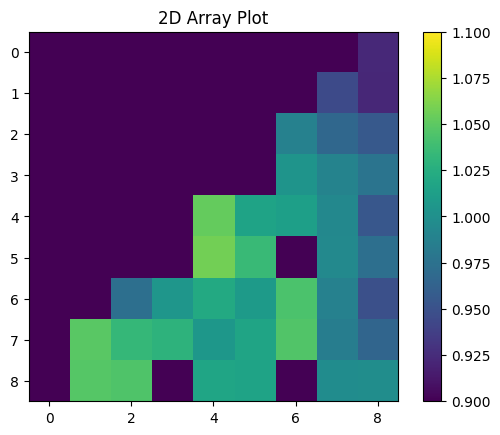

In [38]:
plt.figure()
plt.imshow(dd, cmap='viridis')  # You can change the colormap if desired
plt.title('2D Array Plot')
plt.colorbar()  # Adds a colorbar to show the scale
plt.clim([0.9,1.1])
plt.show()

## Clean up by deleting unwanted files

In [39]:
def delete_runtime_files(directory='.'):
    """
    Deletes all files with a .xml extension, files named statepoint.NNNNN.h5 where N is a digit,
    and the file named summary.h5 in the specified directory.

    Parameters:
    directory (str): The directory to search for files. Defaults to the current directory.
    """
    
    # Regular expression pattern to match files named statepoint.NNNNN.h5
    pattern = re.compile(r'statepoint\.\d{5}\.h5')

    # Iterate through files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Check if the file has a .xml extension, matches the pattern, or is named summary.h5
        if filename.endswith('.xml') or pattern.match(filename) or filename == 'summary.h5' \
           or filename == 'tallies.out':
            # Delete the file
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


# Example usage:
# delete_runtime_files('/path/to/directory')  # specify the directory path if needed

In [40]:
delete_runtime_files('./')
delete_runtime_files(my_path)

Deleted: ./model.xml
Deleted: ./mgxs_casl_2q_homogenized/tallies.out
Deleted: ./mgxs_casl_2q_homogenized/summary.h5
Deleted: ./mgxs_casl_2q_homogenized/statepoint.00150.h5
